# Prévision de volatilité pour timer le facteur Momentum

Nous importons les packages nécessaires. 

In [1]:
import importlib
import modeles
importlib.reload(modeles)

import math
import matplotlib.pyplot as plt
from modeles import forecast_quality_oos, ar1_fit_predict, rolling_window_forecast
from modeles import har_fit_predict, garch_fit_predict, msar1_fit_predict
from modeles import expanding_window_forecast, mom_vol_target_weights
from modeles import rebalance_dates_mask, performance_metrics
from modeles import sklearn_walk_forward, engineer_features, add_targeted_lags

import numpy as np

import os 

import pandas as pd 

import seaborn as sns

from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

from xgboost import XGBRegressor
import yfinance as yf
from tqdm import tqdm
import itertools

import lightgbm as lgb

## Traitement des données

### Import des données

In [2]:
# Importation des données cibles et des variables explicatives depuis le fichier Excel
data = pd.read_excel("data.xlsx", sheet_name="target", skiprows=1)
data_feat = pd.read_excel("data.xlsx", sheet_name="features", skiprows=1)

# Sélection de la variable cible (rendements) et des variables explicatives
target = data.iloc[:, 1:11].copy()
feat = data_feat.iloc[:, 1:30].copy()

# Mise en place de la colonne date comme index
target = target.set_index(target.columns[0])
feat = feat.set_index(feat.columns[0])

# Conversion de l’index en format datetime
target.index = pd.to_datetime(target.index, format="%Y%m%d").copy()

# Forward fill
feat = feat.copy().ffill()

### Analyse des facteurs actions

Les facteurs issus de la base de données de Kenneth French constituent une référence incontournable en finance quantitative et en gestion d’actifs. Largement utilisés dans la littérature académique comme dans la pratique professionnelle, ces facteurs permettent de capturer des sources systématiques de rendement associées à des caractéristiques économiques et financières bien identifiées (taille, value, momentum, etc.). Leur popularité s’explique notamment par leur construction transparente et leur capacité empirique à expliquer une part significative des rendements des actifs financiers.

Dans le cadre de ce travail, ces facteurs jouent un rôle central dans la construction de la stratégie étudiée. Le facteur momentum constitue l’actif principal, dont l’objectif est de prédire la volatilité afin d’en améliorer le timing ultérieur au sein d’une stratégie de portefeuille. Les autres facteurs sont considérés comme des actifs potentiels du portefeuille, susceptibles d’apporter des propriétés complémentaires ou opposées au momentum. Cette diversité de comportements dynamiques en fait des candidats naturels à la diversification, permettant d’enrichir l’allocation et d’améliorer le profil rendement–risque du portefeuille.

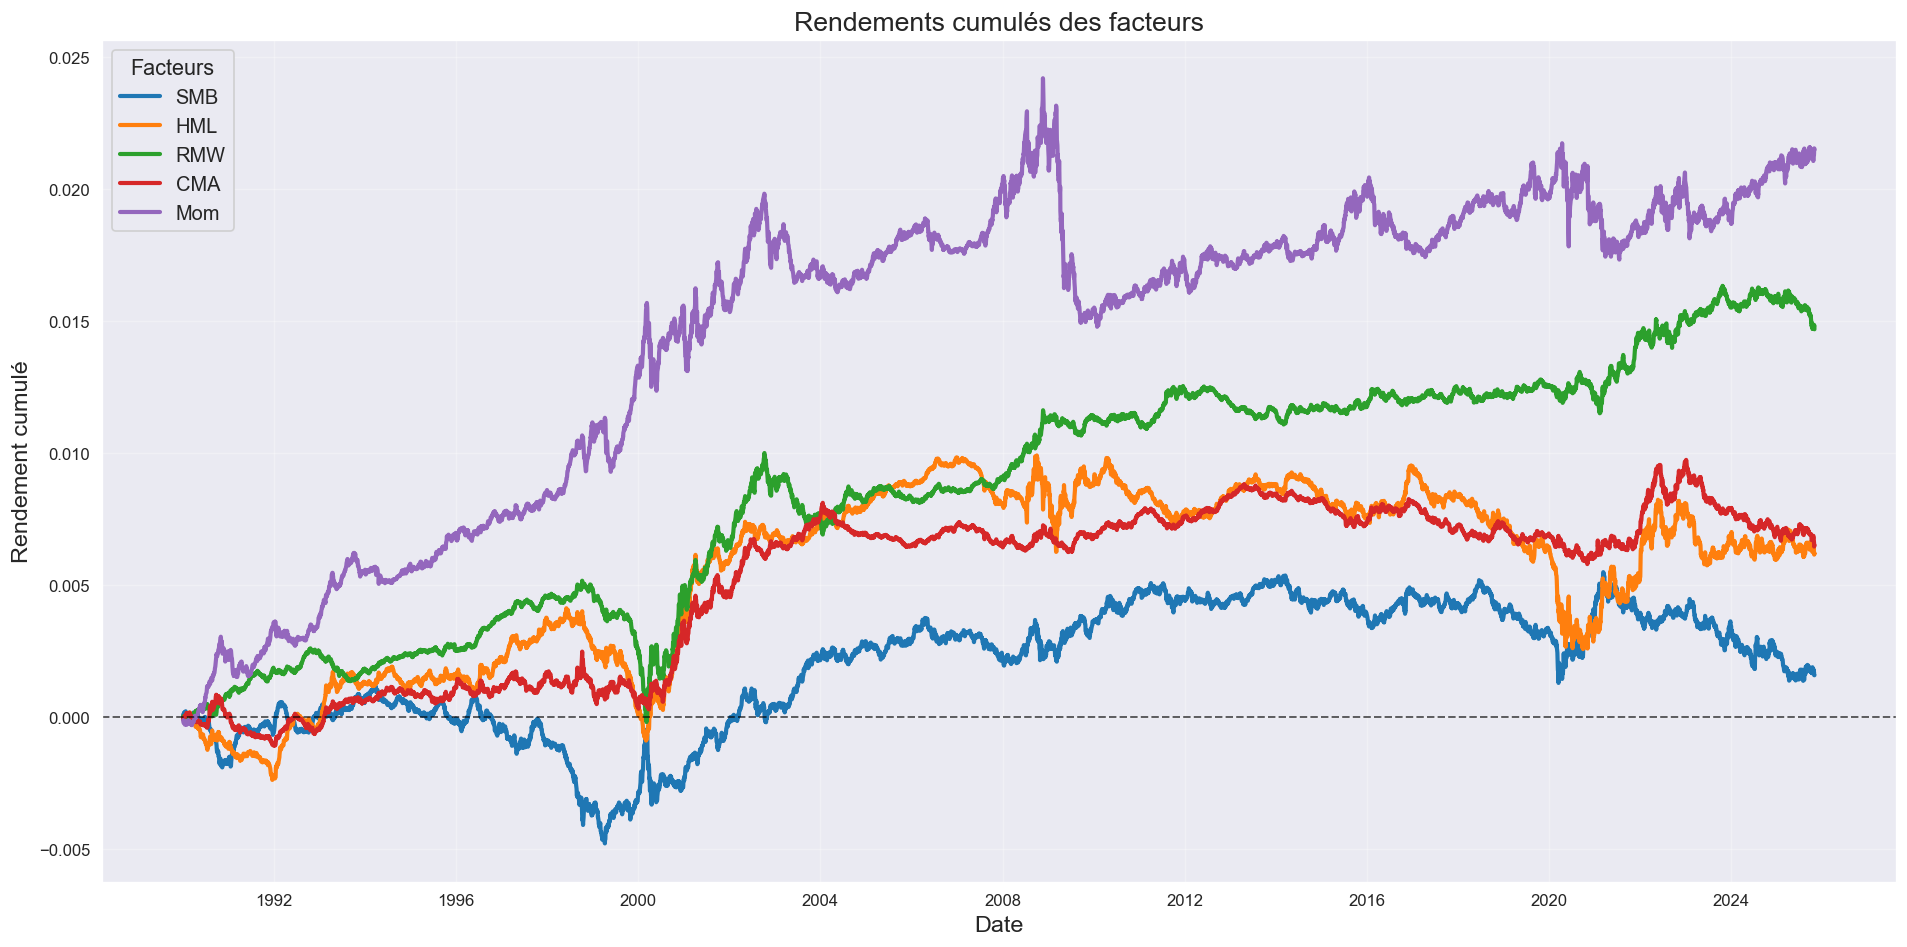

In [3]:
fact = target[["SMB", "HML", "RMW", "CMA", "Mom"]].copy()

# Les facteurs sont exprimées en rendements journaliers (pourcentages) dans la base de données
fact = fact/100 

# Les rendements cummulés servent pour la représentation graphique uniquement
fact_cumsum = (fact.cumsum()/100).copy()

plt.figure(figsize=(16, 8), dpi=120)

for col in fact.columns:
    plt.plot(
        fact_cumsum.index,
        fact_cumsum[col],
        label=col,
        linewidth=2.5
    )

plt.axhline(
    0,
    linestyle="--",
    linewidth=1.2,
    color="black",
    alpha=0.6
)

plt.xlabel("Date", fontsize=14)
plt.ylabel("Rendement cumulé", fontsize=14)
plt.title("Rendements cumulés des facteurs", fontsize=16)

plt.legend(
    title="Facteurs",
    title_fontsize=13,
    fontsize=12,
    loc="upper left",
    frameon=True,
    framealpha=0.9
)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Construction des variances réalisées

Pour un horizon de $h$ jours de trading, la variance réalisée future est définie par :
$
RV^{(h,f)}_t = \sum_{i=1}^{h} r_{t+i}^2,
$
qui correspond à la variance effectivement réalisée sur la période future $[t+1, t+h]$. Les observations sont évaluées sur une grille de dates espacées de $h$ jours, garantissant que deux observations successives de la variable cible ne partagent aucun rendement commun.

Trois horizons sont considérés : journalier ($h=1$), hebdomadaire ($h=5$) et mensuel ($h=21$). 

La variance réalisée future étant strictement positive et fortement asymétrique, l’analyse est conduite sur sa transformation logarithmique,
$
y_t = \log\!\left(RV^{(h,f)}_t\right)
$
afin de stabiliser la variance et de réduire l’influence des observations extrêmes. Les cibles ainsi définies constituent des mesures du risque futur effectivement réalisé sur un horizon donné et servent de base à l’analyse empirique présentée dans la suite.

**Résumé des variables (pandas.Series):**

- ``r`` sont les rendements journaliers du facteur Momentum. Il y a 9026 observation. 

- ``rv_1``, ``rv_5``, ``rv_21`` sont des variances réalisées journalières, hebdomadaires et mensuelles. Elles sont calculées chaque jours, et contiennent respectivement 9026, 9022 et 9006 observations. Nous notons RV les variances réalisées. 

- ``log_rv_1``, ``log_rv_5`` et ``log_rv_21`` sont les RV ``rv_1``, ``rv_5`` et ``rv_21`` en logarithme. La transformation logarithmique est généralement préférée car la variance est très asymétrique, tandis que son logarithme est beaucoup plus proche d’une loi gaussienne et se prête mieux à des modèles linéaires. De plus, le passage en log transforme les chocs de volatilité — empiriquement multiplicatifs — en chocs additifs, ce qui améliore l’interprétation économique et les performances de prévision. Afin d’assurer la stabilité numérique lors du passage au logarithme, nous ajoutons une petite constante espilon à la variance réalisée.

- ``rv_j_1``, ``rv_h_5``, ``rv_m_21`` sont des variances réalisées journalières, hebdomadaires et mensuelles. Elles sont calculées à une fréquence journalière, hebdomadaire et mensuelle de manière à éviter *l'overlap*. En effet, si nous estimions par exemple des RV mensuelles chaque jours alors une grande partie de l'information contenue dans le cible serait présente dans les variables explicatives (*features*). Nous utilions ces RV pour les modèles AR. Elles contiennent respectivement 9026, 1805 et 429 observations. 

- ``log_rv_j_1``, ``log_rv_h_5`` et ``log_rv_m_21`` sont les RV ``rv_j_1``, ``rv_h_5`` et ``rv_m_21`` en logarithme. 

**Résumé des variables (pandas.DataFrame):**

- ``rv_m`` et ``log_rv_m`` contiennent des variances réalisées journalières, hebdomadaires et mensuelles calculées à une fréquence mensuelle. L'utilisation d'un DataFrame permet d'avoir des dates similaires pour les trois types de variance. Ils sont donc utilisées pour les modèles HAR mensuels. 

- ``rv_h`` et ``log_rv_h`` contiennent des variances réalisées journalières, hebdomadaires et mensuelles calculées à une fréquence hebdomadaire. Ils sont donc utilisées pour les modèles HAR hebdomadaires. 

- ``rv_m_as``, ``log_rv_m_as``, ``rv_h_as``, ``log_rv_h_as`` sont les mêmes DataFrames, avec des variables splémentaires, détaillées ci-dessous. Ils sont utilisées pour les HAR-RS, HAR-X, etc. 

In [4]:
# constante pour le passage au logarithme
eps = 1e-12

# Rendements journaliers en décimal
r = target["Mom"].copy() / 100.0

# Variances réalisées, fréquence journalière
rv_1  = r.pow(2).dropna()
rv_5  = r.pow(2).rolling(5).sum().dropna()
rv_21 = r.pow(2).rolling(21).sum().dropna()

# Variances réalisées en logarithme, fréquence journalière
log_rv_21 = np.log(rv_21 + eps)
log_rv_5 = np.log(rv_5 + eps)
log_rv_1 = np.log(rv_1 + eps)

# Variances réalisées fréquence journalière, hebdomadaire et mensuelle
rv_j_1 = rv_1.copy().dropna()
rv_h_5 = rv_5.copy().iloc[::5].dropna()
rv_m_21 = rv_21.copy().iloc[::21].dropna()

# Variances réalisées en logarithme, fréquence journalière, hebdomadaire et mensuelle
log_rv_m_21 = np.log(rv_m_21 + eps)
log_rv_h_5 = np.log(rv_h_5 + eps)
log_rv_j_1 = np.log(rv_j_1 + eps)

**Données pour les HAR :**

Nous regroupons dans un dataframe la série de variance mensuelle à fréquence mensuelle, ainsi que les variances hebdomadaire et journalière. De cette manière nous ne retenons que les dates de la variance mensuelle pour les variances hebdomadaires et journalières afin d'utiliser ce DataFrame pour les HAR mensuels. Il y a 429 observations. Nous créeons également un dataframe basé sur la même méthode à fréquence hebdomadaire, dans lequel il y a 1801 observations. Et enfin nous créeons un dataframe basé sur la même méthode à fréquence journalière avec 9006 observations. 

In [5]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence mensuelle
rv_m = rv_m_21.to_frame("RV 21j").join(rv_5.to_frame("RV 5j"), how = "left")
rv_m = rv_m.join(rv_1.to_frame("RV 1j"), how = "left")

log_rv_m = np.log(rv_m + eps)


In [6]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence hebdomadaire
rv_h = rv_h_5.to_frame("RV 5j").join(rv_21.to_frame("RV 21j"), how = "left")
rv_h = rv_h.join(rv_1.to_frame("RV 1j"), how = "left")
rv_h = rv_h.dropna()

log_rv_h = np.log(rv_h + eps)

In [7]:
# Les 3 séries de variances sont regroupées dans un DataFrame, à fréquence hebdomadaire
rv_j = rv_1.to_frame("RV 1j").join(rv_5.to_frame("RV 5j"), how = "left")
rv_j = rv_j.join(rv_21.to_frame("RV 21j"), how = "left")
rv_j = rv_j.dropna()

log_rv_j = np.log(rv_j + eps)

**Données pour les LHAR :**

Nous enrichissons les variables HAR en ajoutant des semi-variances réalisées négatives et une mesure d’asymétrie (« jump »), définie comme la différence entre la variance associée aux rendements positifs et négatifs, afin de capturer les effets asymétriques de la volatilité. 

In [8]:
# Nous initialisons un DataFrame avec les rendements et la variance journalière
r = target["Mom"].copy() / 100.0
r_asym = pd.concat([r, rv_1], axis = 1)
r_asym.columns = ["r", "rv_1"]

# Décomposition asymétrique de la variance en fonction du signe du rendement
r_asym["rv1_pos"] = np.where(r_asym["r"]>0,r_asym["rv_1"], 0)
r_asym["rv1_neg"] = np.where(r_asym["r"]<0,r_asym["rv_1"], 0)

# Construction des variables asymétriques journalières, hebdomadaires et mensuelles
rv_j_1_pos = r_asym["rv1_pos"]
rv_j_1_neg = r_asym["rv1_neg"]
rv_h_5_pos  = r_asym["rv1_pos"].rolling(5).sum().dropna()
rv_h_5_neg  = r_asym["rv1_neg"].rolling(5).sum().dropna()
rv_m_21_neg = r_asym["rv1_neg"].rolling(21).sum().dropna()
rv_m_21_pos = r_asym["rv1_pos"].rolling(21).sum().dropna()
 
# Mesure d'asymétrie (jump) : différence entre variance positive et négative
jump_m = rv_m_21_pos - rv_m_21_neg
jump_h = rv_h_5_pos - rv_h_5_neg
jump_j = rv_j_1_pos - rv_j_1_neg

# On renomme pour les DataFrames
rv_j_1_neg= rv_j_1_neg.rename("RV1_neg")
rv_h_5_neg= rv_h_5_neg.rename("RV5_neg")
rv_m_21_neg= rv_m_21_neg.rename("RV21_neg")
jump_j = jump_j.rename("Jump_j")
jump_h = jump_h.rename("Jump_h")
jump_m = jump_m.rename("Jump_m")

# Ajout des variables aux dataframes HAR journaliers
rv_j_as = rv_j.join(rv_j_1_neg, how = "left")
rv_j_as = rv_j_as.join(rv_h_5_neg, how = "left")
rv_j_as = rv_j_as.join(rv_m_21_neg, how = "left")
rv_j_as = rv_j_as.join(jump_j, how = "left")
rv_j_as = rv_j_as.join(jump_h, how = "left")
rv_j_as = rv_j_as.join(jump_m, how = "left")

# Ajout des variables aux dataframes HAR hebdomadaires
rv_h_as = rv_h.join(rv_j_1_neg, how = "left")
rv_h_as = rv_h_as.join(rv_h_5_neg, how = "left")
rv_h_as = rv_h_as.join(rv_m_21_neg, how = "left")
rv_h_as = rv_h_as.join(jump_j, how = "left")
rv_h_as = rv_h_as.join(jump_h, how = "left")
rv_h_as = rv_h_as.join(jump_m, how = "left")

# Ajout des variables aux dataframes HAR mensuels
rv_m_as = rv_m.join(rv_j_1_neg, how = "left")
rv_m_as = rv_m_as.join(rv_h_5_neg, how = "left")
rv_m_as = rv_m_as.join(rv_m_21_neg, how = "left")
rv_m_as = rv_m_as.join(jump_j, how = "left")
rv_m_as = rv_m_as.join(jump_h, how = "left")
rv_m_as = rv_m_as.join(jump_m, how = "left")

# colonnes à selectionner pour le logarithme (toutes sauf 'jump')
cols_log_j = rv_j_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])
cols_log_h = rv_h_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])
cols_log_m = rv_m_as.columns.difference(["Jump_j", "Jump_h", "Jump_m"])

# application du log uniquement sur ces colonnes
log_rv_j_as = rv_j_as.copy()
log_rv_h_as = rv_h_as.copy()
log_rv_m_as = rv_m_as.copy()
log_rv_j_as[cols_log_j] = np.log(rv_j_as[cols_log_j]+ eps)
log_rv_h_as[cols_log_h] = np.log(rv_h_as[cols_log_h]+ eps)
log_rv_m_as[cols_log_m] = np.log(rv_m_as[cols_log_m]+ eps)

print(log_rv_j_as)

                RV 1j     RV 5j    RV 21j    RV1_neg    RV5_neg  RV21_neg  \
Date                                                                        
1990-01-30  -9.952468 -9.633155 -8.058788  -9.952468  -9.640662 -8.320394   
1990-01-31 -12.639937 -9.688376 -8.502748 -27.631021  -9.750423 -8.972426   
1990-02-01 -10.442713 -9.308284 -8.410763 -27.631021  -9.750423 -9.051202   
1990-02-02 -10.637040 -9.129406 -8.356308 -27.631021  -9.863882 -9.155000   
1990-02-05 -13.142566 -9.152260 -8.398033 -13.142566  -9.912125 -9.250225   
...               ...       ...       ...        ...        ...       ...   
2025-10-27 -10.720385 -8.042731 -6.776885 -27.631021  -8.668656 -7.075251   
2025-10-28  -9.656627 -8.438243 -6.725259 -27.631021 -12.754254 -7.075251   
2025-10-29  -7.884964 -7.435558 -6.481390 -27.631021 -27.631021 -7.129787   
2025-10-30 -16.223445 -7.507357 -6.798354 -16.223445 -16.223445 -7.862735   
2025-10-31 -10.557029 -7.624069 -6.776367 -10.557029 -10.553575 -7.800281   

**Données pour le LHAR-X :**

Nous ajoutons la série VIX, le taux US 10 ans et l'indice NASDAQ aux DataFrames pour le LHAR-X. 

In [9]:
log_rv_j_as = log_rv_j_as.join(feat["VIXCLS"],  how = "left") 
log_rv_h_as = log_rv_h_as.join(feat["VIXCLS"],  how = "left") 
log_rv_m_as = log_rv_m_as.join(feat["VIXCLS"],  how = "left") 

log_rv_j_as = log_rv_j_as.join(feat["DGS10"],  how = "left") 
log_rv_h_as = log_rv_h_as.join(feat["DGS10"],  how = "left") 
log_rv_m_as = log_rv_m_as.join(feat["DGS10"],  how = "left") 

log_rv_j_as = log_rv_j_as.join(feat["NASDAQCOM"],  how = "left") 
log_rv_h_as = log_rv_h_as.join(feat["NASDAQCOM"],  how = "left") 
log_rv_m_as = log_rv_m_as.join(feat["NASDAQCOM"],  how = "left") 

### Construction des features

Les variables explicatives utilisées dans cette étude proviennent de deux sources de référence largement employées en finance quantitative : Yahoo Finance et la base de données FRED (Federal Reserve Economic Data). Les données issues de Yahoo Finance regroupent des indicateurs de marché classiques tels que les indices actions (S&P 500, Russell 2000), le dollar américain et les obligations à haut rendement, fréquemment mobilisés pour capturer le sentiment de marché, l’appétit pour le risque et les dynamiques de liquidité. Les séries macro-financières extraites de FRED incluent notamment des taux d’intérêt de différentes maturités, des spreads de crédit, des taux de change, des indicateurs monétaires ainsi que l’indice de volatilité implicite (VIX), tous reconnus comme des déterminants majeurs de la volatilité des marchés financiers.

L’ensemble de ces variables constitue un jeu de facteurs standard dans la littérature empirique et la pratique de la gestion d’actifs. Leur pertinence pour la prévision de la volatilité repose sur leur capacité à refléter les conditions macroéconomiques, financières et monétaires affectant directement l’incertitude des marchés. En particulier, les taux d’intérêt, les spreads de crédit et les indicateurs de stress financier sont étroitement liés aux régimes de volatilité, tandis que les indices actions et les variables de change capturent les cycles de risque globaux. Ces caractéristiques en font des variables explicatives naturelles pour modéliser et anticiper la volatilité du facteur momentum.

Pour la construction de nouvelles features, nous utilisons la fonction ``engineer_featuresCette`` qui a pour objectif de transformer automatiquement des séries financières brutes en un ensemble de variables explicatives exploitables pour la modélisation de la volatilité. Elle applique un feature engineering standard en finance quantitative, en distinguant les variables de prix (indices actions, matières premières, taux de change) des variables de niveau (taux d’intérêt, spreads de crédit, VIX).

Pour les variables traitées comme des prix, la fonction extrait des informations de rendement, de volatilité et de tendance. Elle calcule notamment les rendements journaliers, des mesures de volatilité historique à court et moyen terme, ainsi qu’un indicateur de tendance mesurant l’écart du prix à sa moyenne mobile de long terme (200 jours). Ces transformations permettent de capturer à la fois la dynamique de marché, les régimes de volatilité et la persistance des mouvements de prix. Les séries de prix sont transformées en rendements afin de travailler sur des variables plus stationnaires et économiquement informatives, tout en limitant les problèmes de multicolinéarité et de dépendance mécanique propres aux niveaux de prix. Les mesures de volatilité construites à partir de ces rendements permettent en outre de capter la persistance et la propagation du risque entre marchés, éléments centraux pour expliquer et anticiper les régimes de volatilité du facteur momentum.

Pour les autres variables, assimilées à des taux ou des niveaux macro-financiers, la fonction se concentre sur les variations, les cycles et l’incertitude associée. Elle construit des variations quotidiennes, des écarts par rapport à une moyenne de long terme et des mesures de volatilité à différentes horizons. Enfin, les séries de niveau sont conservées afin de préserver l’information de régime. L’ensemble des variables est nettoyé des valeurs infinies et des observations incomplètes, ce qui garantit une base de données cohérente et directement utilisable pour l’estimation et la prévision de la volatilité.

In [10]:
# Variable cible : log-variance réalisée à 5 jours
y_target = log_rv_j["RV 5j"].copy()

# Point de départ 
X_base = log_rv_j[["RV 1j", "RV 5j", "RV 21j"]].copy()

# Contruction de nouvelles features (redements, volatilités)
X_fred_eng = engineer_features(feat, price_cols=["NASDAQCOM", "DCOILWTICO"])

# Ajout des variables macro-financières FRED 
X = X_base.copy().join(X_fred_eng, how="left")

# La volatilité n'a pas de sens pour les taux sans risques
X = X.drop(["DGS3MO_vol21", "DGS3MO_vol5", "DGS3MO_vol1", "DTB3_vol21", "DTB3_vol5", "DTB3_vol1" ], axis =1)

X = X.copy().dropna()

# Ajout des variables de marché issues de Yahoo Finance
tickers = {"Dollar": "DX-Y.NYB", "JunkBond": "VWEHX", "SP500": "^GSPC", "Russell": "^RUT"}
yf_data = yf.download(list(tickers.values()), start="1989-01-01", progress=False)["Close"]
yf_data.columns = list(tickers.keys())
yf_data = yf_data.ffill()

# Contruction de nouvelles features pour les variables YahooFinance (redements, volatilités)
X_yahoo_eng = engineer_features(yf_data, price_cols=list(yf_data.columns))
X = X.join(X_yahoo_eng, how="left")

Des variables retardées sont également introduites afin de capturer la dynamique temporelle et la persistance des processus financiers, la volatilité étant connue pour présenter des effets de mémoire et d’inertie à court et moyen terme.

In [11]:
target_suffixes = ["ret1d", "chg1d", "gap200", "level"]

# On ajoute des RV aux variables dont on veut des lags
target_vars = ["RV 1j", "RV 5j"]

X_lag = add_targeted_lags(X.copy(), suffixes=target_suffixes, extra_cols=target_vars)

# dimension
print(f"{X.shape[1]} -> {X_lag.shape[1]} variables")
print(X_lag.info())

Lagging de 34 variables sur 86
86 -> 222 variables
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9000 entries, 1990-02-07 to 2025-10-31
Columns: 222 entries, RV 1j to Russell_ret1d_lag5
dtypes: float64(222)
memory usage: 15.3 MB
None


/Users/alexd/PycharmProjects/Projet_Ml_Momentum/modeles.py:692: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[new_col_name] = df[col].shift(lag)
/Users/alexd/PycharmProjects/Projet_Ml_Momentum/modeles.py:692: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_out[new_col_name] = df[col].shift(lag)
/Users/alexd/PycharmProjects/Projet_Ml_Momentum/modeles.py:692: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

Pour les modèles qui suivent, nous nous concentrons sur la log-varaince hebdomadaire qui constitue un compromis pour les stratégies de portefeuille entre deux éléments. Le premier est la réactivité de l'ajustement du portefeuille aux signaux de volatilité, plus les signaux sont fréquents et plus le portefeuille peut s'ajuster rapidement et éviter les crash Momentum. Le second élément ce sont les coûts de transactions, nous savons qu'un portefeuille ne peut pas être rebalancé à une fréquence journalière car les coûts de transactions seraient trop élevés. 

In [13]:
y_shifted = y_target.shift(-5).dropna()

# On garde uniquement les dates présentes dans la cible et dans toutes les dataset
common_idx = y_shifted.index.intersection(X_lag.index)

# Alignement index commun
y_aligned = y_shifted.loc[common_idx]
X_aligned = X_lag.loc[common_idx]

print(f"Période d'analyse : du {common_idx[0].date()} au {common_idx[-1].date()}")
print(f"Nombre d'observations : {len(common_idx)}")

Période d'analyse : du 1990-02-07 au 2025-10-24
Nombre d'observations : 8995


## Analyse des volatilitées

Prédire les rendements financiers est notoirement difficile. Les rendements sont fortement bruités, faiblement autocorrélés, et leur composante prévisible est généralement très faible à haute fréquence. En revanche, la volatilité présente des propriétés statistiques beaucoup plus favorables à la prédiction.

Premièrement, la volatilité est persistante : elle présente une forte autocorrélation et des phénomènes de clustering bien documentés. Deuxièmement, elle réagit de manière asymétrique aux chocs négatifs, ce qui la rend sensible à l’état du marché. Enfin, de nombreux modèles empiriques (GARCH, HAR, modèles à facteurs latents) montrent que la volatilité est bien décrite par des dynamiques lentes et prévisibles.

Dans ce contexte, prédire la volatilité — plutôt que les rendements — permet de se concentrer sur une variable plus stable, plus structurée, et économiquement plus exploitable. 



Nous calculons les volatilitées annualisées du facteur Momentum. 

In [14]:
# Volatilités annualisées
vol_1_ann  = np.sqrt(252 * rv_1)
vol_5_ann  = np.sqrt(252/5 * rv_5)
vol_21_ann = np.sqrt(252/21 * rv_21)

Le facteur Momentum est l’un des facteurs empiriques les plus robustes documentés en finance. Il repose sur une régularité simple : les actifs ayant récemment bien performé ont tendance à continuer de surperformer à court et moyen terme, tandis que ceux ayant sous-performé continuent souvent de sous-performer. Formellement, une stratégie momentum consiste à acheter les actifs ayant les rendements passés les plus élevés et à vendre ceux ayant les rendements passés les plus faibles, typiquement sur des horizons de 3 à 12 mois.

Un point central de la littérature est que le lien entre volatilité et rendement est particulièrement marqué pour le facteur Momentum. Contrairement à l’intuition classique d’un arbitrage rendement-risque positif, de nombreux travaux montrent que les périodes de forte volatilité du Momentum sont associées à des rendements futurs faibles, voire négatifs.

Ce phénomène s’explique notamment par la nature du Momentum, qui génère des pertes importantes lors de retournements de marché brusques. Les crashes du Momentum sont souvent concentrés après des périodes de forte volatilité ou de transitions macroéconomiques.

Empiriquement, il est observé que la volatilité du Momentum augmente fortement avant et pendant ces épisodes de pertes extrêmes, ce qui suggère que la volatilité contient une information prédictive sur le risque asymétrique du facteur.

Nous pouvons observer ce phénomène sur nos données ci-dessous.

Nous représentons graphiquement la volatilité hebdomadaire annualisée ainsi que la performance cummulée du facteur Momentum.

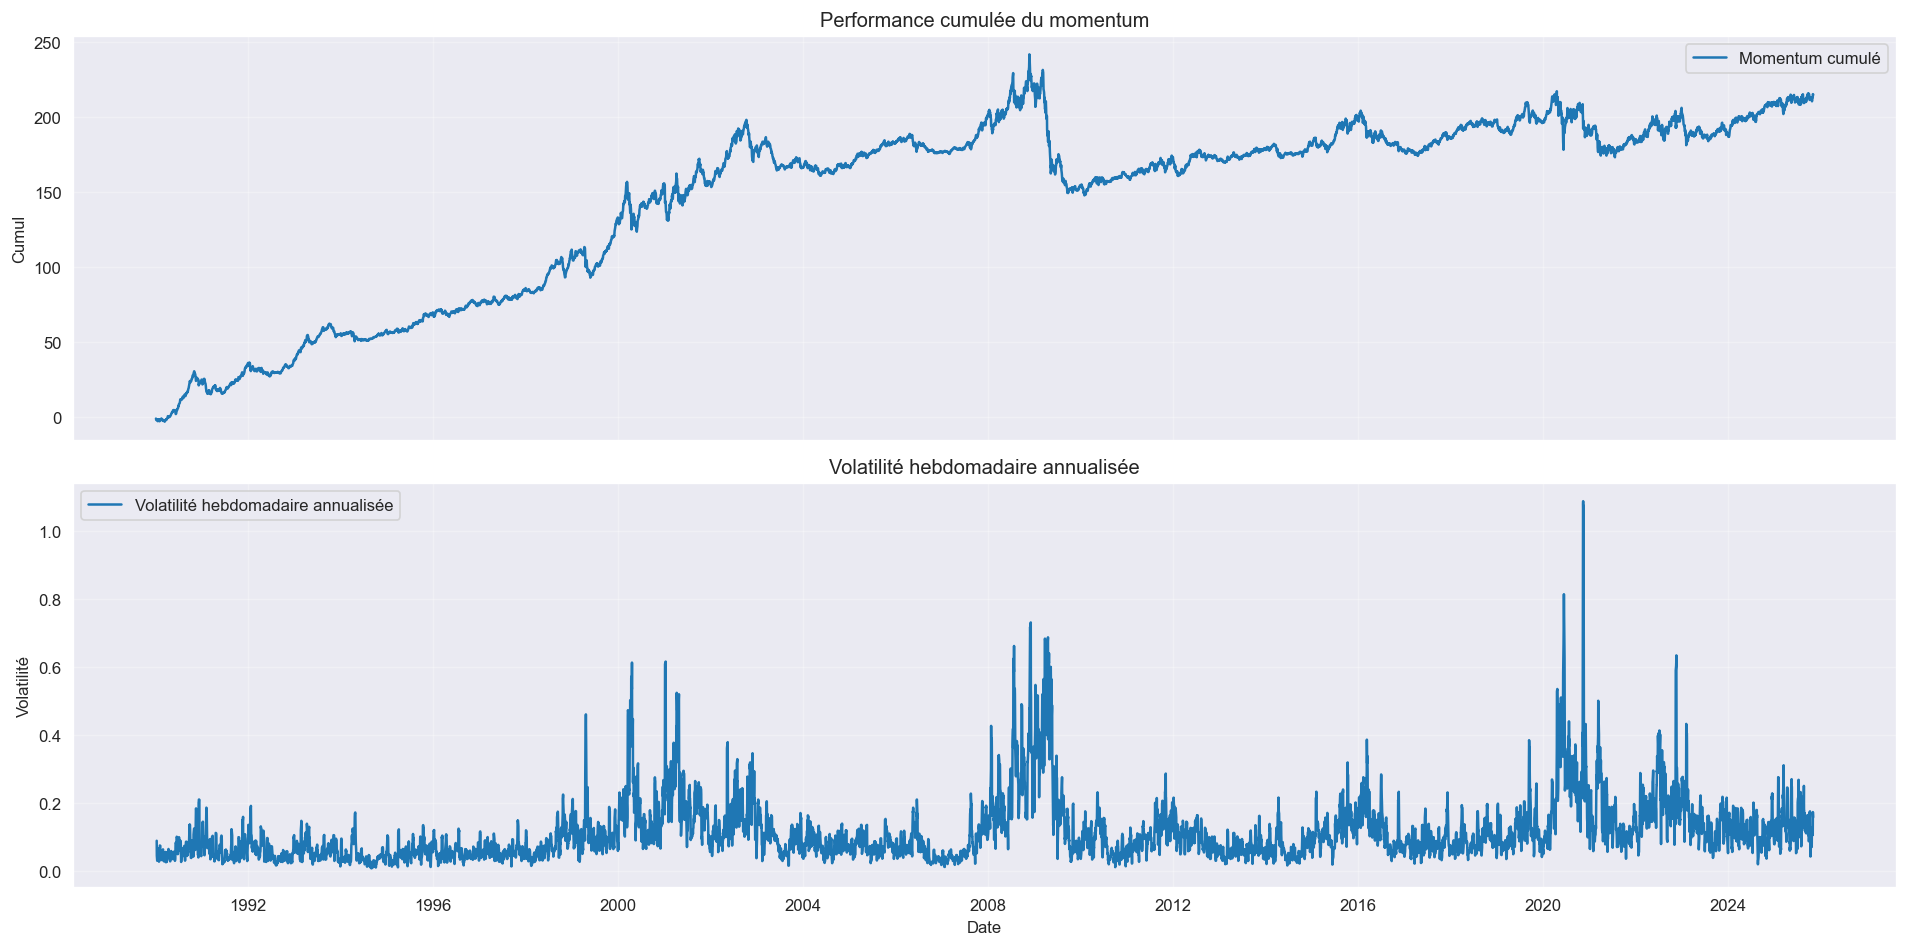

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), dpi=120, sharex=True)

# Graph 1 : cumul du momentum
mom_cum = target['Mom'].cumsum()
axes[0].plot(mom_cum.index, mom_cum, label="Momentum cumulé")
axes[0].set_title("Performance cumulée du momentum")
axes[0].set_ylabel("Cumul")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graph 2 : volatilité hebdomadaire annualisée
axes[1].plot(vol_5_ann.index, vol_5_ann, label="Volatilité hebdomadaire annualisée")
axes[1].set_title("Volatilité hebdomadaire annualisée")
axes[1].set_ylabel("Volatilité")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Prédiction de variance

La prévision de la volatilité occupe une place centrale en finance, tant pour la gestion du risque que pour la prise de décision en allocation d’actifs. Contrairement aux rendements, faiblement prévisibles, la volatilité présente une forte persistance et une dynamique bien structurée, ce qui a conduit au développement de nombreux modèles dédiés, tels que les modèles autorégressifs (AR), le modèle HAR ou encore les modèles de type GARCH.

L’objectif de ce projet est d’évaluer la capacité prédictive de ces modèles classiques de prévision de la volatilité appliqués au facteur Momentum, et de comparer leurs performances à celles de modèles de machine learning, susceptibles de mieux capturer des relations non linéaires et des dynamiques complexes.

Au-delà de la performance statistique des prévisions, ce projet vise également à examiner leur utilité économique. En particulier, nous analysons dans quelle mesure les prévisions de volatilité peuvent être exploitées dans des stratégies de portefeuille, par exemple via des ajustements dynamiques de l’exposition au facteur Momentum, afin d’anticiper indirectement la performance future et de mieux contrôler le risque.


### Last Value (Benchmark)

Comme benchmark, nous retenons une spécification de type marche aléatoire pour la log-variance, dans laquelle la log-variance prédite à la date $t+1$ est égale à la log-variance observée à la date t. Ce benchmark exploite la forte persistance, proche d’une racine unitaire, largement documentée dans les séries de volatilité financière. En conséquence, l’information marginale contenue dans des variables explicatives supplémentaires est souvent limitée à court horizon, ce qui rend ce benchmark particulièrement difficile à surpasser hors échantillon. Il constitue ainsi une référence exigeante pour évaluer les gains prédictifs réels apportés par des modèles plus complexes, qu’ils soient économétriques ou issus de l’apprentissage automatique.


On se place en février 2010 pour comparer avec tous les autres modèles. 

In [17]:
log_rv_h_5_2010 = log_rv_h_5.loc["2010-02-01":]
log_rv5_rw_fcst =log_rv_h_5_2010.shift(1) 

oos_metrics = forecast_quality_oos(
    y_true=log_rv_h_5_2010,
    y_pred=log_rv5_rw_fcst
)

print(oos_metrics)

N_OOS     792.000000
MSPE        1.014185
RMSE        1.007068
MAE         0.772901
R2_OOS      0.278178
dtype: float64


### Modèles AR

Comme points de départ, nous considérons des modèles linéaires standards pour la prévision de la volatilité, qui servent de références dans la littérature. Le modèle autorégressif d’ordre un (AR(1)) suppose que la volatilité future dépend uniquement de sa dernière réalisation observée. Appliqué à la variance réalisée future à horizon $h$, le modèle s’écrit :
$
y_t = \alpha + \rho\, y_{t-1} + \varepsilon_t,
$
où $y_t = \log(RV^{(h,f)}_t)$ désigne la transformation logarithmique de la variance réalisée future. Ce modèle capture la forte persistance empirique de la volatilité et constitue un benchmark naturel pour évaluer la performance de modèles plus complexes.

Les modèles AR(1) utilisé pour prédire la log-variance hebdomadaire (resp. mensuelle) utilisent une série de log-variance hebdomadaire (resp. mensuelle) calcuée toutes les semaines (resp. mois) pour éviter l'overlapping. 



**AR(1) hebdomadaire** :

In [18]:
log_rv5_ar1_fcst = rolling_window_forecast(
    y=log_rv_h_5,
    fit_predict_fn=ar1_fit_predict,
    window=520,
)

log_rv5_ar1_fcst_2010 = log_rv5_ar1_fcst.loc["2010-02-01":]

oos_metrics = forecast_quality_oos(
    y_true=log_rv_h_5,
    y_pred=log_rv5_ar1_fcst_2010
)

print(oos_metrics)

N_OOS     793.000000
MSPE        0.868686
RMSE        0.932033
MAE         0.722734
R2_OOS      0.381161
dtype: float64


### Modèles HAR :

Nous considérons également une spécification de type Heterogeneous Autoregressive (HAR) aussi appelé  Heterogeneous AutoRegressive – Realized Volatility (HAR-RV), largement utilisée pour modéliser la volatilité réalisée. L’idée du modèle HAR est que la volatilité présente une dynamique multi-horizon : les composantes de court, moyen et long terme (par exemple à fréquence journalière, hebdomadaire et mensuelle) contribuent conjointement à expliquer la volatilité à venir. Dans notre cadre, le modèle HAR s’écrit :

$ y_t = \alpha + \beta_d y_{t-1} + \beta_w y^{(5)}_{t-1}+ \beta_m y^{(21)}_{t-1}+ \varepsilon_t,$

où $y^{(5)}_{t-1}$ et $y^{(21)}_{t-1}$ désignent les composantes hebdomadaire et mensuelle de la volatilité, construites à partir de $y_t$ et observables à la date de prévision. Cette spécification fournit une approximation simple d’une dynamique à mémoire longue, tout en restant linéaire et facilement interprétable.

Pour la prédiction de log-variance hebdomadaire et mensuelle avec les modèles HAR, la variable endogène est une série de log-variance hebdomadaire (resp mensuelle) calculée comme le log de la somme des variance journalière. Comme pour les modèles AR, ces séries sont calculées à fréquence hebdomadaire ou mensuelle pour éviter l'overlapping. 

**Modèles HAR hebdomadaires :**

In [19]:
y_H = log_rv_h["RV 5j"]              # cible mensuelle
X_H = log_rv_h[["RV 1j", "RV 5j", "RV 21j"]]  # D, W, M

log_rv5_har_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520,
    X=X_H,
)

oos_metrics_har = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_har_fcst
)

print(oos_metrics_har)

N_OOS     1281.000000
MSPE         0.723989
RMSE         0.850876
MAE          0.664835
R2_OOS       0.568439
dtype: float64


### HARSJ

Nous étendons le modèle HAR afin de tenir compte des asymétries de la volatilité et de la nature directionnelle des chocs. En effet, de nombreux travaux montrent que les chocs négatifs sur les rendements contiennent plus d’information sur la volatilité future que les chocs positifs de même ampleur, en particulier en période de stress. Le modèle HAR with Realized Semivariance (HAR-RS) permet ainsi de distinguer l’impact des mouvements baissiers et haussiers et le modèle HAR with Signed Jumps (HAR-SJ) d’introduire une composante directionnelle des chocs, améliorant la capacité du modèle à capturer la dynamique non linéaire de la volatilité réalisée.

Dans le HAR-SJ/HAR-RS classique, ces composantes sont construites à partir de rendements intra-journaliers et agrégées au niveau journalier afin de prédire la volatilité réalisée du jour suivant. Dans notre cadre, la variable dépendante étant définie à une fréquence journalière, hebdomadaire ou mensuelle, nous adaptons cette approche en construisant des mesures d’asymétrie et de sauts signés à partir des données journalières agrégées sur l'horizon temporel considéré.

À partir des rendements journaliers $r_t$, on définit ainsi la semi-variance négative agrégée
$
SV_t^- = \sum_{j=0}^{h-1} r_{t-j}^2 \mathbf{1}_{\{r_{t-j}<0\}},
$
et le saut signé agrégé
$
Jump_t = \sum_{j=0}^{h-1} r_{t-j}^2 \big(\mathbf{1}_{\{r_{t-j}\ge 0\}} - \mathbf{1}_{\{r_{t-j}<0\}}\big),
$
où $h$ correspond à l’horizon de    prévision considéré. Le modèle HAR-RS classique inclue la semi-variance négative et positive, tandis que le modèle HAR-SJ inclue le jump. Nous ne considérons que la semi-variance négative et le jump, le modèle utilisé que l'on appelera HAR-RS s’écrit alors :
$ y_t = \alpha + \beta_d y_{t-1}+ \beta_w y^{(5)}_{t-1}+ \beta_m y^{(21)}_{t-1}+ \gamma SV_{t-1}^-+ \delta Jump_{t-1}+ \varepsilon_t.$

Si l'on considère par exemple la prévision de log-variance hebdomadaire, le modèle HAR-RS est estimé avec une série de log-variance hebdomadaire calculée à partir de données journalière comme variable dépendante. Les semi-variances et le saut sont également calculé comme une agrégation hebdomadaire de données journalières. 


In [20]:
y_H = log_rv_h_as["RV 5j"]
X_H = log_rv_h_as[["RV 1j", "RV 5j", "RV 21j", "RV5_neg", "Jump_h"]]  # D, W, M

log_rv5_lhar_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520, #780 
    X=X_H
)

log_rv5_lhar_fcst_2010 = log_rv5_lhar_fcst.loc["2010-02-01":]

oos_metrics_lhar = forecast_quality_oos(
    y_true=y_H.loc["2010-02-01":],
    y_pred=log_rv5_lhar_fcst_2010
)

print(oos_metrics_lhar)

N_OOS     793.000000
MSPE        0.755254
RMSE        0.869054
MAE         0.666429
R2_OOS      0.461968
dtype: float64


### HARSJ-X


Le modèle HAR-RS-X est simplement un modèle HAR-RS auquel est rajouté une ou plusieurs variables exogènes. Pour rester parcimonieux nous ne considérons qu'une seule variable exogène par modèle. Le modèle avec la variable VIX est retenu.  


In [21]:
y_H = log_rv_h_as["RV 5j"]
X_H = log_rv_h_as[["RV 1j", "RV 5j", "RV 21j", "RV5_neg", "Jump_h", "VIXCLS"]]  # features (features du HAR + semi-variance mensuelle négative et "jump")

log_rv5_harx_fcst = rolling_window_forecast(
    y=y_H,
    fit_predict_fn=har_fit_predict,
    window=520, # 780 ou 520
    X=X_H,
)

log_rv5_harx_fcst_2010 = log_rv5_harx_fcst.loc["2010-02-05":]


oos_metrics_har = forecast_quality_oos(
    y_true=y_H,
    y_pred=log_rv5_harx_fcst_2010
)

print(oos_metrics_har)

N_OOS     792.000000
MSPE        0.729147
RMSE        0.853901
MAE         0.654304
R2_OOS      0.481047
dtype: float64


### Modèles GARCH, GJR et EGARCH

Contrairement aux autres modèles, les modèles de type GARCH sont estimés à partir de rendements journaliers et produisent des prévisions de variance conditionnelle à chaque horizon futur. À partir de ces prévisions journalières, le modèle génère successivement les $h$ variances prévues à l’horizon $1,\dots,h$, que nous agrégeons ensuite par sommation. La prévision finale de log-variance à l’horizon $h$ est obtenue en appliquant une transformation logarithmique à cette variance agrégée, ce qui permet de rendre les résultats comparables aux autres approches.

Le modèle GARCH(1,1) capture la persistance de la variance conditionnelle en reliant celle-ci aux chocs passés et à sa propre dynamique. Le modèle s'écrit : 
$$
r_t = \mu + \varepsilon_t, 
\qquad \varepsilon_t = \sigma_t z_t,
$$
où $z_t$ est une innovation standardisée de moyenne nulle et de variance unitaire. La variance conditionnelle suit alors la dynamique :
$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 + \beta \sigma_{t-1}^2,
$$
avec $\omega > 0$, $\alpha,\beta \ge 0$ et $\alpha + \beta < 1$ pour assurer la stationnarité.

Le modèle EGARCH (Exponential GARCH) modélise la dynamique de la variance sur une échelle logarithmique, ce qui garantit sa positivité sans imposer de contraintes paramétriques explicites :
$$
\log \sigma_t^2 = \omega + \beta \log \sigma_{t-1}^2 
+ \alpha \left( \frac{|\varepsilon_{t-1}|}{\sigma_{t-1}} - \mathbb{E}|z| \right)
+ \gamma \frac{\varepsilon_{t-1}}{\sigma_{t-1}}.
$$

Le terme asymétrique $\gamma$ permet de capturer l'effet de levier, selon lequel les chocs négatifs ont un impact plus important sur la volatilité future. Cette flexibilité améliore souvent les performances prédictives, notamment lors de périodes de stress de marché.

Le modèle GJR-GARCH introduit une asymétrie directement dans la dynamique de la variance conditionnelle via un indicateur de chocs négatifs :
$$
\sigma_t^2 = \omega + \alpha \varepsilon_{t-1}^2 
+ \gamma \mathbb{I}_{\{\varepsilon_{t-1}<0\}} \varepsilon_{t-1}^2
+ \beta \sigma_{t-1}^2.
$$

Ce modèle permet de distinguer l'impact des rendements négatifs et positifs sur la variance future.

Dans les modèles de type GARCH, l’hypothèse de distribution porte sur les innovations standardisées. Plus précisément, si $\varepsilon_t$ désigne le choc de rendement et $\sigma_t^2$ la variance conditionnelle, on écrit :
$$
\varepsilon_t = \sigma_t z_t,
\qquad z_t \sim \mathcal{D}(0,1),
$$
où $\mathcal{D}$ désigne une loi centrée et de variance unitaire.

Plusieurs choix sont possibles pour la distribution de $z_t$, notamment la loi normale, la loi de Student, ou des distributions plus flexibles telles que la loi de Student asymétrique ou la loi GED (Generalized Error Distribution). Dans ce travail, nous retenons principalement les spécifications gaussienne et Student, cette dernière permettant de mieux capturer les queues épaisses fréquemment observées dans les rendements financiers.

**Prévision de variance hebdomadaire (GARCH Student):**

In [22]:
rv5_garch_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =2520, #2520 (10 ans) ou 3780 (15 ans)
    horizon = 5, 
    step = 5,
    o = 0, # 1 pour le GJR, 0 sinon
    mean = "Constant", # Zero ou Constant
    vol="EGARCH",      # GARCH ou EGARCH
    dist = "t"  # t pour Student et normal pour normale
    )

eps = 1e-12
log_rv5_garch_fcst = np.log(rv5_garch_fcst + eps)
log_rv5_garch_fcst_2010 = log_rv5_garch_fcst.loc["2010-02-01":]

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_5,
    y_pred=log_rv5_garch_fcst_2010
)

print(oos_metrics_garch)

N_OOS     793.000000
MSPE        0.785671
RMSE        0.886381
MAE         0.683726
R2_OOS      0.440299
dtype: float64


**Prévision de variance hebdomadaire (GJR):**

In [23]:
rv5_gjr_fcst = rolling_window_forecast(
    y=r,
    fit_predict_fn=garch_fit_predict,
    window =2520, #2520 (10 ans) ou 3780 (15 ans)
    horizon = 5, 
    step = 5,
    o = 1, # 1 pour le GJR, 0 sinon
    mean = "Constant", # Zero ou Constant
    vol="GARCH",      # GARCH ou EGARCH
    dist = "normal"  # t pour Student et normal pour normale
    )

eps = 1e-12
log_rv5_garch_fcst = np.log(rv5_garch_fcst + eps)
log_rv5_garch_fcst_2010 = log_rv5_garch_fcst.loc["2010-02-01":]

oos_metrics_garch = forecast_quality_oos(
    y_true=log_rv_5,
    y_pred=log_rv5_garch_fcst_2010
)

print(oos_metrics_garch)


N_OOS     793.000000
MSPE        0.785671
RMSE        0.886381
MAE         0.683726
R2_OOS      0.440299
dtype: float64


### Elastic Net

In [24]:
import warnings
warnings.filterwarnings('ignore')

Les modèles économétriques classiques (type HAR ou GARCH) sont performants pour capturer la persistance de la volatilité, mais ils peinent à intégrer un grand nombre de variables exogènes sans souffrir de sur-apprentissage (*overfitting*).

Pour exploiter notre large base de données (indicateurs macroéconomiques, taux, spreads, VIX, rendements passés), nous utilisons l'**ElasticNet**. Ce modèle nous permet de conserver une approche linéaire interprétable tout en sélectionnant automatiquement les prédicteurs les plus pertinents.

#### 1. Fonctionnement du modèle
L'ElasticNet est une régression linéaire qui combine deux types de pénalités de régularisation :
* **Lasso ($L_1$) :** Favorise la *sparsité* en forçant les coefficients des variables peu explicatives à zéro (sélection de variables).
* **Ridge ($L_2$) :** Réduit la magnitude des coefficients pour limiter la variance, particulièrement efficace lorsque les variables sont fortement corrélées entre elles (multicolinéarité).

L'objectif est de minimiser la fonction de perte suivante :
$$\min_{w} \frac{1}{2n} ||y - Xw||_2^2 + \alpha \rho ||w||_1 + \frac{\alpha(1-\rho)}{2} ||w||_2^2$$

#### 2. Méthodologie d'entraînement : Walk-Forward
Afin de garantir la robustesse de nos prévisions et d'éviter tout *Look-Ahead Bias*, nous appliquons une procédure rigoureuse de **Validation Walk-Forward Imbriquée** :

1.  **Fenêtre Roulante :** Le modèle est entraîné sur une fenêtre glissante (ex: 15 ans) pour s'adapter aux changements de régime de marché.
2.  **Optimisation Dynamique :** À chaque pas de temps, une grille de recherche (*Grid Search*) est effectuée sur le passé récent pour déterminer les hyperparamètres optimaux ($\alpha$ et `l1_ratio`).
3.  **Prévision Hors-Échantillon :** La volatilité est prédite pour le jour suivant ($t+h$) en utilisant uniquement les informations disponibles en $t$.

In [25]:
pipeline_en = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", ElasticNet(max_iter=10000, random_state=42, selection='random'))
])

param_grid_en = {
    "reg__alpha": [0.01,0.1, 1.0, 5],
    "reg__l1_ratio": [0.1, 0.5, 0.9, 1.0]
}

df_res_en, df_params_en, df_imps_en = sklearn_walk_forward(
    base_model=pipeline_en,
    param_grid=param_grid_en,
    X=X_aligned,
    y=y_aligned,
    train_window_size=15*252,
    val_window_size=5*252,
    refit_step=60
)

100%|██████████| 3955/3955 [00:19<00:00, 202.86it/s]


In [26]:
metrics = forecast_quality_oos(
    y_true=df_res_en["Actual"],
    y_pred=df_res_en["Pred"]
)
print(metrics)

N_OOS     3955.000000
MSPE         0.701229
RMSE         0.837394
MAE          0.657341
R2_OOS       0.500181
dtype: float64


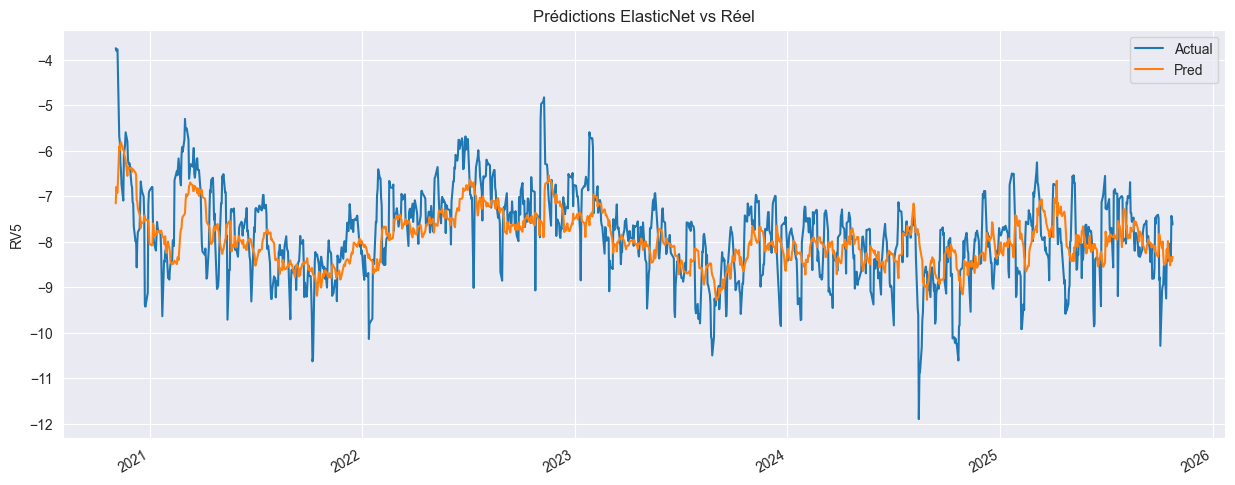

In [27]:
plt.figure(figsize=(15, 6))
df_res_en.iloc[-1250:].plot(ax=plt.gca(), title="Prédictions ElasticNet vs Réel")
plt.ylabel("RV5")
plt.show()

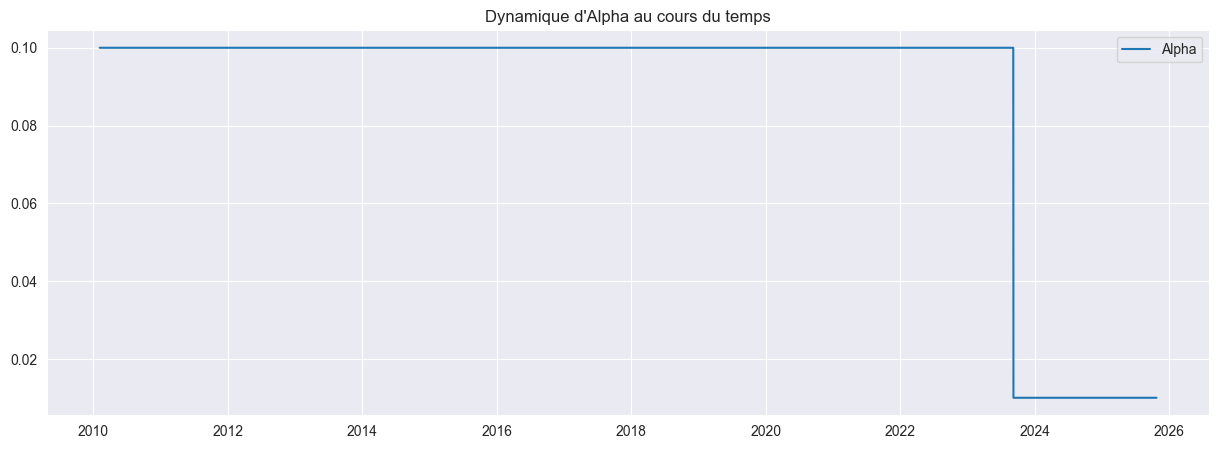

In [28]:
plt.figure(figsize=(15, 5))
plt.plot(df_params_en.index, df_params_en["reg__alpha"], label="Alpha")
plt.title("Dynamique d'Alpha au cours du temps")
plt.legend()
plt.show()

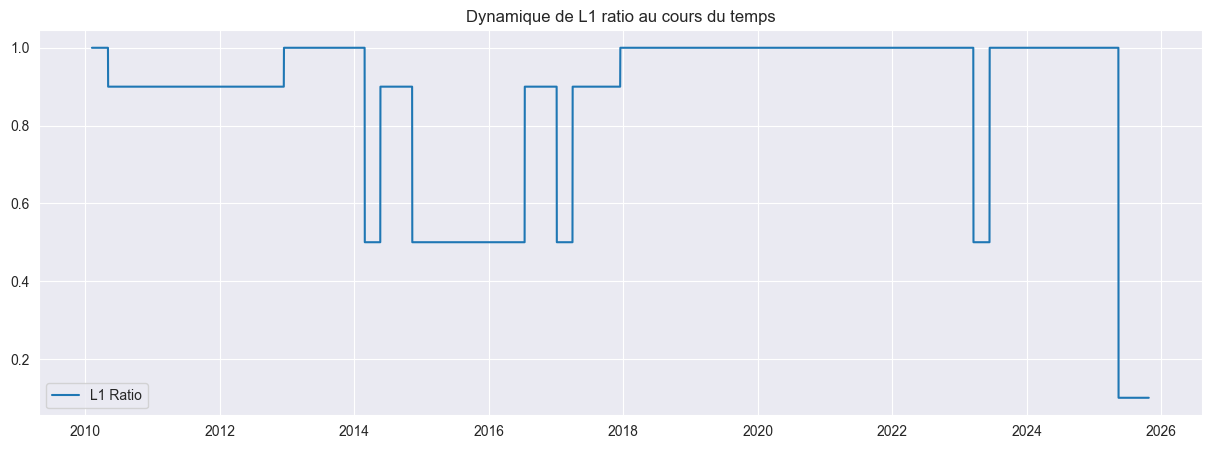

In [29]:
plt.figure(figsize=(15, 5))
plt.plot(df_params_en.index, df_params_en["reg__l1_ratio"], label="L1 Ratio")
plt.title("Dynamique de L1 ratio au cours du temps")
plt.legend()
plt.show()

In [30]:
mean_importances = df_imps_en.abs().mean().sort_values(ascending=False).head(10)

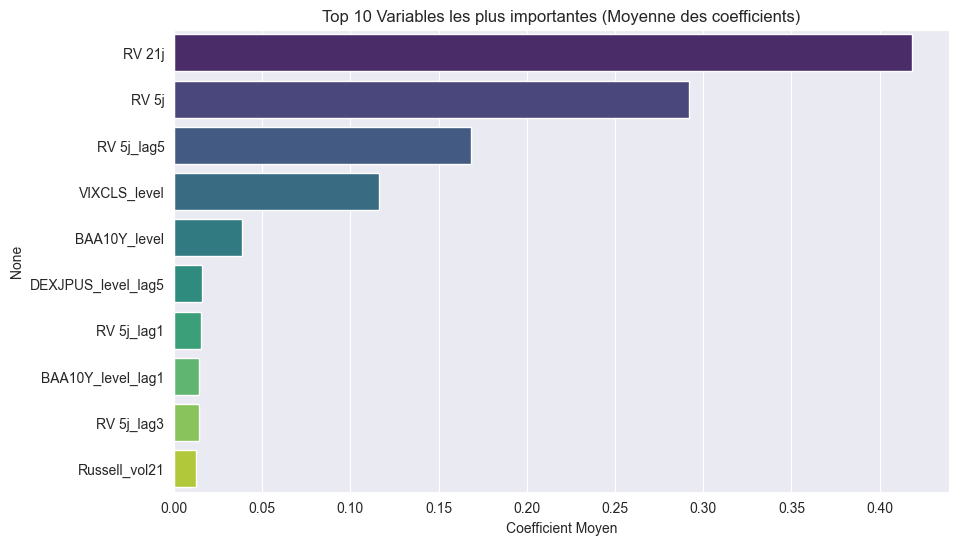

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_importances.values, y=mean_importances.index, palette="viridis")
plt.title("Top 10 Variables les plus importantes (Moyenne des coefficients)")
plt.xlabel("Coefficient Moyen")
plt.show()

### LightGBM

#### 1. Motivation : Capturer la complexité du marché
Alors que l'ElasticNet suppose une relation linéaire entre les variables macro-économiques et la volatilité future, la réalité des marchés financiers est souvent non-linéaire. Par exemple, l'impact d'une hausse des taux peut être négligeable en temps calme, mais dévastateur en période de stress (effet de seuil).

Pour capturer ces interactions complexes et ces asymétries, nous utilisons **LightGBM** (Light Gradient Boosting Machine), un algorithme basé sur des arbres de décision, reconnu pour sa rapidité et sa performance.

#### 2. Fonctionnement du modèle
LightGBM est une méthode d'ensemble de type **Boosting**. Contrairement au Random Forest qui construit des arbres indépendants en parallèle, le Boosting construit les arbres de manière séquentielle :
* Chaque nouvel arbre tente de corriger les erreurs (résidus) commises par les arbres précédents.
* Le modèle final est la somme pondérée de centaines de "modèles faibles" (petits arbres).

Ses avantages pour notre projet sont :
* **Non-linéarité :** Capte naturellement les interactions (ex: "Si VIX > 30 ET Spreads > 2%, alors Volatilité élevée").
* **Efficacité :** Optimisé pour la vitesse de calcul et la faible consommation mémoire.

#### 3. Méthodologie et Contrôle du Risque
Les modèles d'arbres sont sujets au sur-apprentissage (*overfitting*) sur les données financières bruitées. Nous appliquons donc des contraintes strictes via notre Grid Search :
* **Max Depth (3 à 5) :** Nous limitons la profondeur des arbres pour forcer le modèle à ne capturer que les signaux les plus robustes.
* **Learning Rate :** Nous testons des taux d'apprentissage faibles pour construire le modèle progressivement et réduire la variance.

In [32]:
from lightgbm import LGBMRegressor

lgbm_base = LGBMRegressor(
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    importance_type='gain'
)

param_grid_lgbm = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300],
    "max_depth": [3, 5],
}

In [33]:
df_res_lgbm, df_params_lgbm, df_imps_lgbm = sklearn_walk_forward(
    base_model=lgbm_base,
    param_grid=param_grid_lgbm,
    X=X_aligned,
    y=y_aligned,
    train_window_size=15 * 252,
    val_window_size=5 * 252,
    refit_step=60
)

100%|██████████| 3955/3955 [05:55<00:00, 11.14it/s]


On trie les résultats par RMSE croissant pour identifier la configuration la plus performante

In [34]:
metrics = forecast_quality_oos(
    y_true=df_res_lgbm["Actual"],
    y_pred=df_res_lgbm["Pred"]
)
print(metrics)

N_OOS     3955.000000
MSPE         0.723004
RMSE         0.850296
MAE          0.669348
R2_OOS       0.484661
dtype: float64


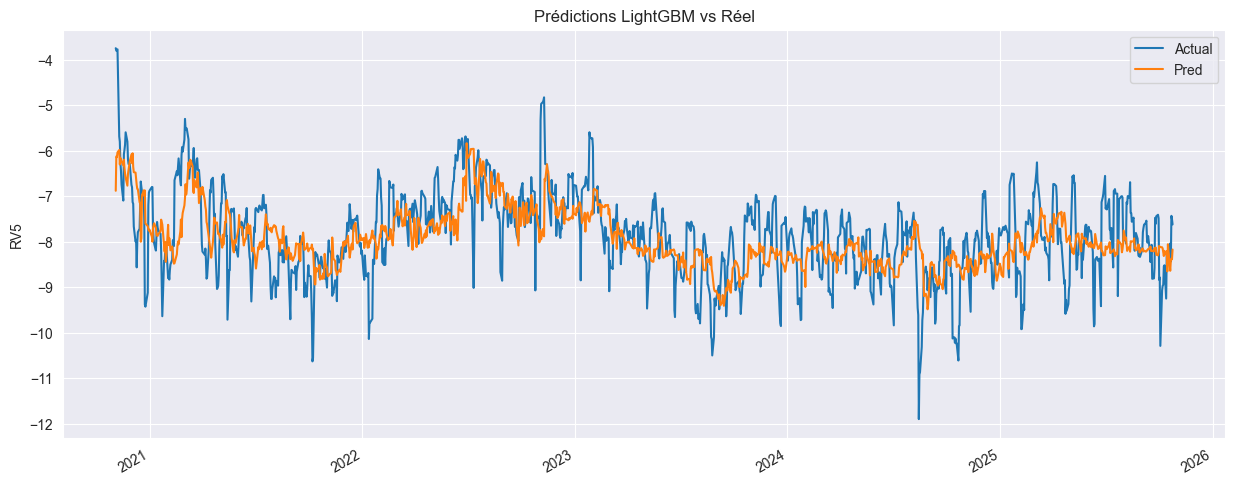

In [35]:
plt.figure(figsize=(15, 6))
df_res_lgbm.iloc[-1250:].plot(ax=plt.gca(), title="Prédictions LightGBM vs Réel")
plt.ylabel("RV5")
plt.show()

In [36]:
mean_importances = df_imps_lgbm.mean().sort_values(ascending=False).head(10)

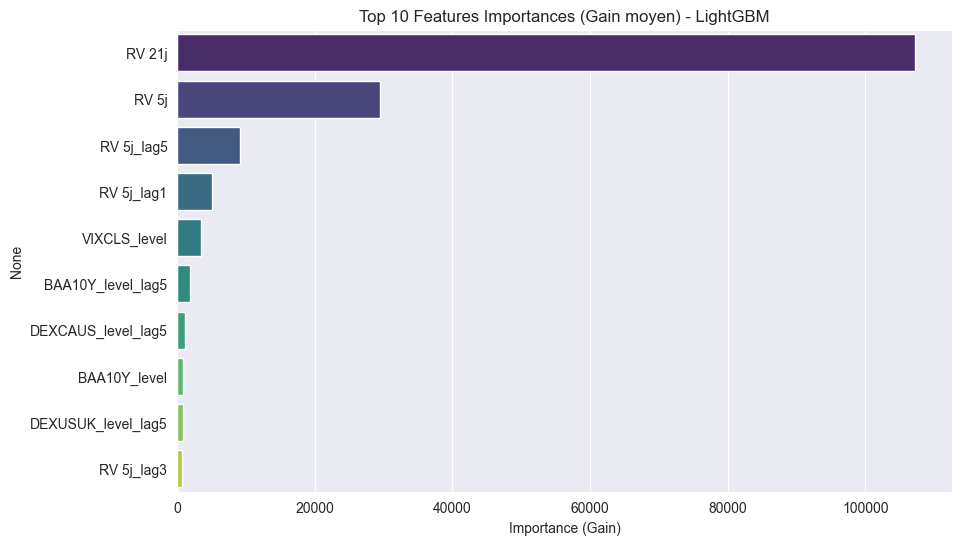

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_importances.values, y=mean_importances.index, palette="viridis")
plt.title("Top 10 Features Importances (Gain moyen) - LightGBM")
plt.xlabel("Importance (Gain)")
plt.show()

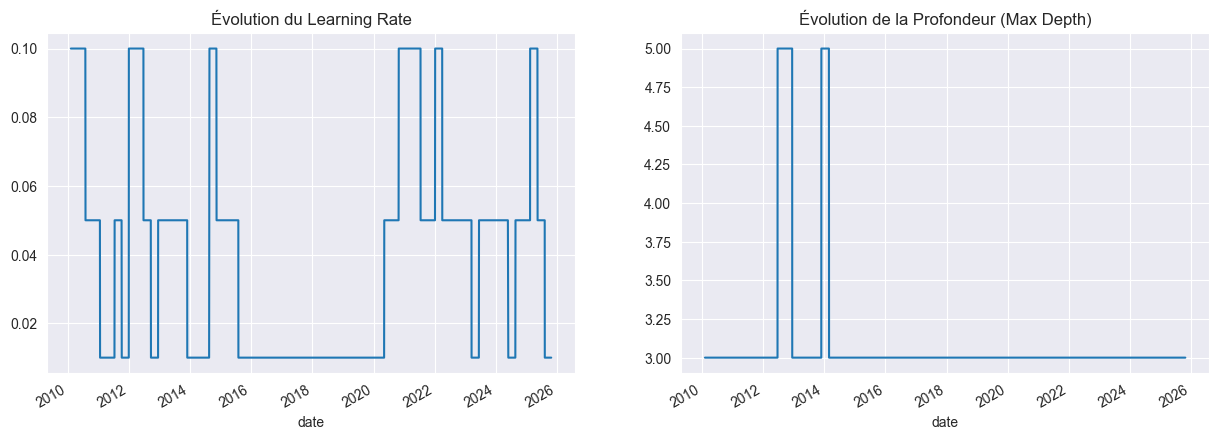

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_params_lgbm["learning_rate"].plot(ax=axes[0], title="Évolution du Learning Rate")
df_params_lgbm["max_depth"].plot(ax=axes[1], title="Évolution de la Profondeur (Max Depth)")
plt.show()

### Voting Regressor

Après avoir optimisé nos modèles individuellement, nous construisons ici un Méta-Modèle (Ensemble) pour stabiliser les prédictions Out-of-Sample.

L'objectif est de combiner deux visions mathématiques complémentaires :
1.  Composante liénaire de l'ElasticNet
2.  Composante non linéaire de LightGBM

Le `VotingRegressor` effectue une moyenne pondérée des prédictions à chaque pas de temps $t$ :

$$\hat{y}_{ensemble} = w_{lin} \cdot \hat{y}_{ElasticNet} + w_{boost} \cdot \hat{y}_{LightGBM}$$

*L'hypothèse est que cette diversification réduit la variance globale de l'erreur (RMSE) en lissant les erreurs spécifiques à chaque modèle.*

In [39]:
from sklearn.ensemble import VotingRegressor

In [40]:
pipe_en = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", ElasticNet(random_state=42))
])

pipe_lgbm = Pipeline([
    ("reg", LGBMRegressor(n_jobs=-1, random_state=42, verbose=-1))
])

ensemble_model = VotingRegressor(
    estimators=[
        ('elastic_net', pipe_en),
        ('lightgbm', pipe_lgbm)
    ],
    n_jobs=-1
)

param_grid_ensemble = {

    "elastic_net__reg__alpha": [0.1, 1.0],

    "lightgbm__reg__n_estimators": [100, 300],
    "lightgbm__reg__learning_rate": [0.01, 0.05],
    "lightgbm__reg__max_depth": [3],

    "weights": [
        [0.5, 0.5]
    ]
}

In [41]:
df_res_ens, df_params_ens, _ = sklearn_walk_forward(
    base_model=ensemble_model,
    param_grid=param_grid_ensemble,
    X=X_aligned,
    y=y_aligned,
    train_window_size=15 * 252,
    val_window_size=5 * 252,
    refit_step=60
)

  0%|          | 0/3955 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. 

In [42]:
metrics = forecast_quality_oos(
    y_true=df_res_ens["Actual"],
    y_pred=df_res_ens["Pred"]
)
print(metrics)

N_OOS     3955.000000
MSPE         0.700871
RMSE         0.837181
MAE          0.657162
R2_OOS       0.500436
dtype: float64


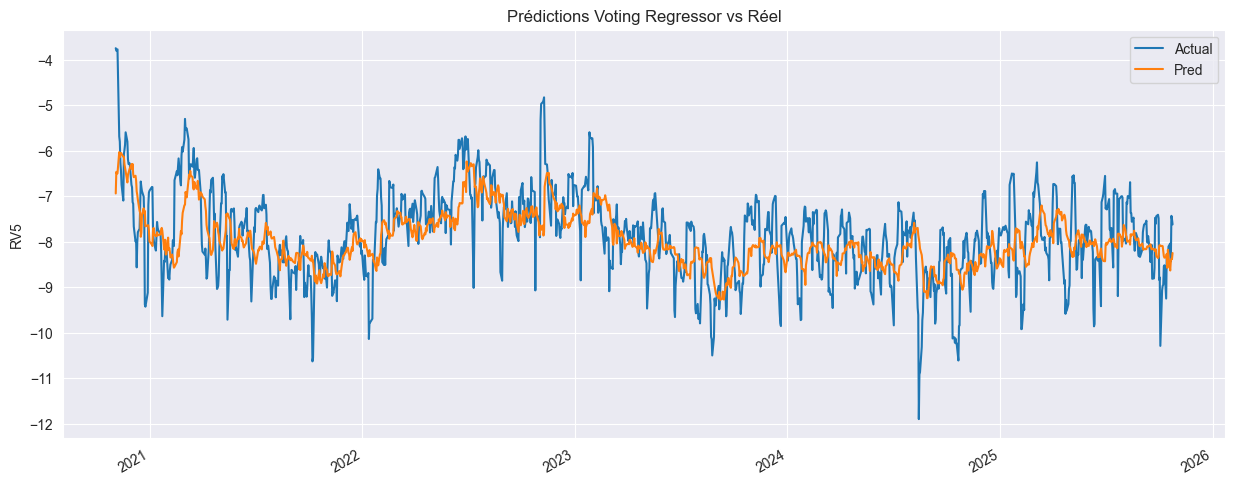

In [43]:
plt.figure(figsize=(15, 6))
df_res_ens.iloc[-1250:].plot(ax=plt.gca(), title="Prédictions Voting Regressor vs Réel")
plt.ylabel("RV5")
plt.show()

### MLP

In [44]:
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor

In [45]:
inner_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", MLPRegressor(
        solver='adam',
        activation='relu',
        early_stopping=True,
        validation_fraction=0.1,
        max_iter=500,
        random_state=42
    ))
])

model_nn_base = TransformedTargetRegressor(
    regressor=inner_pipe,
    transformer=StandardScaler()
)

param_grid_nn = {
    "regressor__reg__hidden_layer_sizes": [(32, 16), (64, 32), (32,)],

    "regressor__reg__alpha": [0.01, 0.1, 0.5],

    "regressor__reg__learning_rate_init": [0.001, 0.01]
}

In [46]:
df_res_nn, df_params_nn, _ = sklearn_walk_forward(
    base_model=model_nn_base,
    param_grid=param_grid_nn,
    X=X_aligned,
    y=y_aligned,
    train_window_size=15 * 252,  # 15 ans d'apprentissage pur
    val_window_size=5 * 252,     # 5 ans de validation pour choisir les params
    refit_step=30                # On ré-optimise tous les mois (env. 30 jours)
)

100%|██████████| 3955/3955 [05:32<00:00, 11.89it/s]


In [47]:
metrics_nn = forecast_quality_oos(y_true=df_res_nn["Actual"], y_pred=df_res_nn["Pred"])
print("\n--- Performance MLP (Optimisé) ---")
print(metrics_nn)


--- Performance MLP (Optimisé) ---
N_OOS     3955.000000
MSPE         0.828705
RMSE         0.910333
MAE          0.713520
R2_OOS       0.409319
dtype: float64


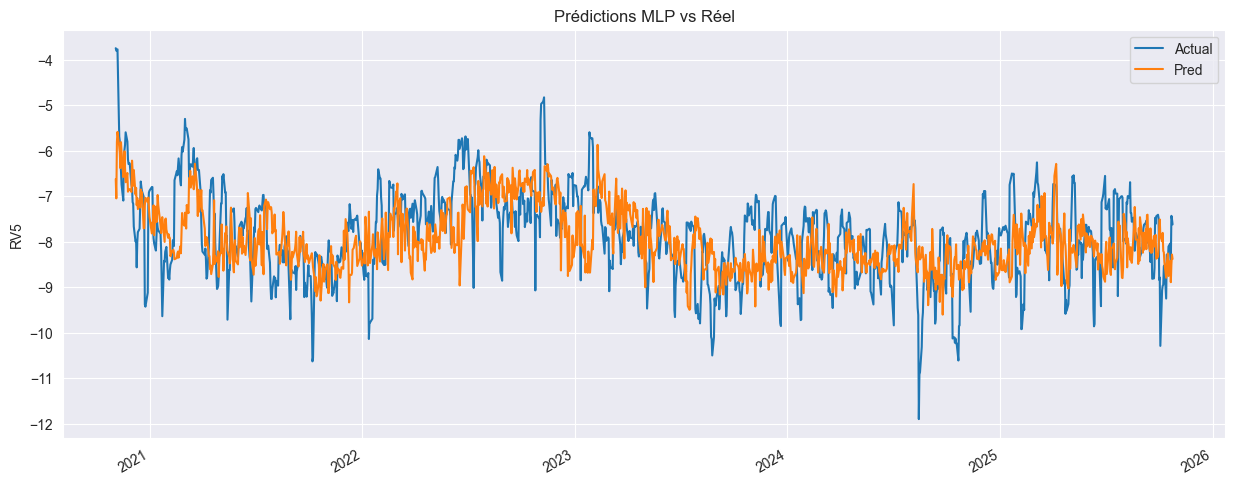

In [48]:
plt.figure(figsize=(15, 6))
df_res_nn.iloc[-1250:].plot(ax=plt.gca(), title="Prédictions MLP vs Réel")
plt.ylabel("RV5")
plt.show()

## Portefeuille

#### Alignements des prévisions de variances

In [49]:
def align_predictions(predictions_dict):
    """
    Ne garde que les dates communes à toutes les séries de prédictions fournies.

    Args:
        predictions_dict (dict): Dictionnaire { "Nom_Modele": serie_prediction, ... }

    Returns:
        pd.DataFrame: Un DataFrame où chaque colonne est un modèle,
                      et l'index ne contient que les dates présentes partout.
    """
    df_aligned = pd.concat(predictions_dict, axis=1, join='inner')

    return df_aligned

On regroupe les séries

In [50]:
all_preds = align_predictions({
    "LHAR-X-VIX" : log_rv5_harx_fcst_2010,
    "EN": df_res_en["Pred"],
    "LGBM": df_res_lgbm["Pred"],
    "ENS": df_res_ens["Pred"],
    "MLP": df_res_nn["Pred"],

})

print(f"Période commune : du {all_preds.index[0].date()} au {all_preds.index[-1].date()}")
print(f"Nombre de jours : {len(all_preds)}")

Période commune : du 2010-02-10 au 2025-10-23
Nombre de jours : 791


#### Construction des actifs et rendements pour le portefeuille 

In [51]:
# On clacule le "rendement" journalier du Tbills 3M
tbills_ret = feat["DGS3MO"] / (100*252)

### Benchmark

In [52]:
# Pour pouvoir comparer avec les modèles on se place début 2010
fact_2010 = fact.loc["2010-02-10":]
metrics_mom = performance_metrics(fact_2010["Mom"])
print(metrics_mom)


Mean annual return     0.041771
Annual volatility      0.153813
Sharpe ratio           0.271569
Max drawdown          -0.396507
Skewness              -1.347334
Kurtosis              16.266892
Hit ratio              0.535001
dtype: float64


### Volatility targeting hebdomadaire

Comme les poids seront souvent hedbomadaires, nous faisons une fonction pour les étendre (ffill) en journalier car nos rendements sont journaliers. 

In [53]:
def expand_daily_weights(df):
    """
    Prend un DataFrame indexé par date (dates irrégulières)
    et retourne un DataFrame journalier avec forward-fill.
    """
    df = df.sort_index()

    daily_index = pd.date_range(
        start=df.index.min(),
        end=df.index.max(),
        freq="D"
    )

    return (
        df
        .reindex(daily_index)
        .ffill()
    )

Nous créeons une fonction qui calcul les poids du portefeuille selon la règle du volatility targeting. 

In [54]:
def run_strategy_backtest(
    predictions,
    factor_returns,
    risk_free_rate,
    model_name,
    target_vol=0.20,
    rebalance_freq="D"
):

    rb = rebalance_dates_mask(predictions, rebalance_freq=rebalance_freq)
    print(f"Avg Rebalance/Year: {rb.sum()/52:.2f}")

    # Calcul des Poids Cibles
    weights = mom_vol_target_weights(
        log_var_mom_fcst=predictions,
        rb=rb,
        target_vol_annual=target_vol,
        w_max=2.0,
        no_trade_band=0.03, # pas de rebalancement si le changement de poids est inférieur à 3%
        trading_days = 52
    )
    daily_weights = expand_daily_weights(weights)

    common_idx = daily_weights.index.intersection(factor_returns.index)
    daily_weights = daily_weights.loc[common_idx]

    # Calcul du PnL
    rp = (
        daily_weights["w_mom"] * factor_returns.loc[common_idx]
        + daily_weights["w_def"] * risk_free_rate.loc[common_idx]
    ).dropna()

    metrics = performance_metrics(rp)
    print(metrics)

    turnover = weights.diff().abs().sum(axis=1).fillna(0.0)

    cost_per_period = 0.0001 * turnover

    annual_cost = cost_per_period.mean() * 52

    print(f"Annual Cost: {annual_cost:.5f}")
    print("\n")

    return metrics, annual_cost

In [55]:
models_to_test = [
    ("LHAR-X", all_preds["LHAR-X-VIX"]),
    ("ElasticNet", all_preds["EN"]),
    ("LightGBM",   all_preds["LGBM"]),
    ("Ensemble",   all_preds["ENS"]),
    ("MLP",        all_preds["MLP"])
]

results = {}

vol target = 5%

In [60]:
for name, preds in models_to_test:
    print(name)
    met, cost  = run_strategy_backtest(
        predictions=preds,
        factor_returns=fact_2010["Mom"],
        risk_free_rate=tbills_ret,
        model_name=name,
        target_vol=0.05
    )
    results[name] = {"metrics": met, "cost": cost}

LHAR-X
Avg Rebalance/Year: 15.21
Mean annual return    0.038539
Annual volatility     0.060710
Sharpe ratio          0.634809
Max drawdown         -0.124060
Skewness             -0.480822
Kurtosis              1.987523
Hit ratio             0.541635
dtype: float64
Annual Cost: 0.00077


ElasticNet
Avg Rebalance/Year: 15.21
Mean annual return    0.038155
Annual volatility     0.058606
Sharpe ratio          0.651055
Max drawdown         -0.122412
Skewness             -0.552234
Kurtosis              2.403926
Hit ratio             0.541635
dtype: float64
Annual Cost: 0.00057


LightGBM
Avg Rebalance/Year: 15.21
Mean annual return    0.038140
Annual volatility     0.059799
Sharpe ratio          0.637798
Max drawdown         -0.129483
Skewness             -0.407545
Kurtosis              1.101958
Hit ratio             0.541635
dtype: float64
Annual Cost: 0.00059


Ensemble
Avg Rebalance/Year: 15.21
Mean annual return    0.038284
Annual volatility     0.059321
Sharpe ratio          0.645375
Ma

vol target = 7,5%

In [68]:
for name, preds in models_to_test:
    print(name)
    met, cost  = run_strategy_backtest(
        predictions=preds,
        factor_returns=fact_2010["Mom"],
        risk_free_rate=tbills_ret,
        model_name=name,
        target_vol=0.075
    )
    results[name] = {"metrics": met, "cost": cost}

LHAR-X
Avg Rebalance/Year: 15.21
Mean annual return    0.051210
Annual volatility     0.090972
Sharpe ratio          0.562922
Max drawdown         -0.175761
Skewness             -0.473201
Kurtosis              1.999602
Hit ratio             0.539357
dtype: float64
Annual Cost: 0.00119


ElasticNet
Avg Rebalance/Year: 15.21
Mean annual return    0.050030
Annual volatility     0.088155
Sharpe ratio          0.567527
Max drawdown         -0.181919
Skewness             -0.563588
Kurtosis              2.443919
Hit ratio             0.539104
dtype: float64
Annual Cost: 0.00088


LightGBM
Avg Rebalance/Year: 15.21
Mean annual return    0.049733
Annual volatility     0.089831
Sharpe ratio          0.553631
Max drawdown         -0.189987
Skewness             -0.425384
Kurtosis              1.221133
Hit ratio             0.539357
dtype: float64
Annual Cost: 0.00092


Ensemble
Avg Rebalance/Year: 15.21
Mean annual return    0.049452
Annual volatility     0.089189
Sharpe ratio          0.554464
Ma

vol target = 10%

In [61]:
for name, preds in models_to_test:
    print(name)
    met, cost  = run_strategy_backtest(
        predictions=preds,
        factor_returns=fact_2010["Mom"],
        risk_free_rate=tbills_ret,
        model_name=name,
        target_vol=0.10
    )
    results[name] = {"metrics": met, "cost": cost}

LHAR-X
Avg Rebalance/Year: 15.21
Mean annual return    0.062387
Annual volatility     0.120870
Sharpe ratio          0.516145
Max drawdown         -0.230404
Skewness             -0.491114
Kurtosis              2.042865
Hit ratio             0.538092
dtype: float64
Annual Cost: 0.00147


ElasticNet
Avg Rebalance/Year: 15.21
Mean annual return    0.060753
Annual volatility     0.117277
Sharpe ratio          0.518028
Max drawdown         -0.238464
Skewness             -0.574252
Kurtosis              2.452676
Hit ratio             0.537839
dtype: float64
Annual Cost: 0.00114


LightGBM
Avg Rebalance/Year: 15.21
Mean annual return    0.060884
Annual volatility     0.119697
Sharpe ratio          0.508647
Max drawdown         -0.250465
Skewness             -0.429099
Kurtosis              1.225375
Hit ratio             0.538092
dtype: float64
Annual Cost: 0.00121


Ensemble
Avg Rebalance/Year: 15.21
Mean annual return    0.060878
Annual volatility     0.118915
Sharpe ratio          0.511943
Ma

vol target = 15%

In [63]:
for name, preds in models_to_test:
    print(name)
    met, cost  = run_strategy_backtest(
        predictions=preds,
        factor_returns=fact_2010["Mom"],
        risk_free_rate=tbills_ret,
        model_name=name,
        target_vol=0.15
    )
    results[name] = {"metrics": met, "cost": cost}

LHAR-X
Avg Rebalance/Year: 15.21
Mean annual return    0.079283
Annual volatility     0.174142
Sharpe ratio          0.455280
Max drawdown         -0.335306
Skewness             -0.555931
Kurtosis              2.332286
Hit ratio             0.535054
dtype: float64
Annual Cost: 0.00139


ElasticNet
Avg Rebalance/Year: 15.21
Mean annual return    0.079546
Annual volatility     0.171021
Sharpe ratio          0.465126
Max drawdown         -0.331506
Skewness             -0.582923
Kurtosis              2.383943
Hit ratio             0.535561
dtype: float64
Annual Cost: 0.00116


LightGBM
Avg Rebalance/Year: 15.21
Mean annual return    0.078832
Annual volatility     0.174454
Sharpe ratio          0.451883
Max drawdown         -0.351080
Skewness             -0.461319
Kurtosis              1.421077
Hit ratio             0.535054
dtype: float64
Annual Cost: 0.00126


Ensemble
Avg Rebalance/Year: 15.21
Mean annual return    0.077078
Annual volatility     0.173267
Sharpe ratio          0.444851
Ma